# Performer: Rethinking Attention with Performers


## Introduction to Performer
 
Performer, introduced by Choromanski et al. in 2020, is an efficient variant of the attention mechanism. It addresses the quadratic complexity problem of standard attention by using a kernel-based formulation of attention combined with the Fast Attention Via Orthogonal Random Features (FAVOR+) algorithm.
  
The key idea is to approximate the softmax attention using a kernel function and random feature maps, reducing the complexity from O(n^2) to O(n), where n is the sequence length, while allowing for unbound sequence lengths.


In [19]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

torch.manual_seed(42)

# Our example phrase
phrase = "The quick brown fox jumps over the lazy dog"
words = phrase.split()
sequence_length = len(words)

# Hyperparameters
batch_size = 1
embedding_dim = 8
num_heads = 2
head_dim = embedding_dim // num_heads
num_features = 16  # Number of random features for FAVOR+

# Create a simple embedding for our words
word_to_idx = {word: idx for idx, word in enumerate(words)}
embeddings = torch.randn(len(words), embedding_dim)

# Input
X = embeddings.unsqueeze(0)  # Add batch dimension
print("Input shape:", X.shape)

# Weight matrices
W_q = torch.randn(embedding_dim, embedding_dim)
W_k = torch.randn(embedding_dim, embedding_dim)
W_v = torch.randn(embedding_dim, embedding_dim)
W_o = torch.randn(embedding_dim, embedding_dim)


Input shape: torch.Size([1, 9, 8])


## Performer's Random Feature Maps
  
The core of Performer's efficiency comes from the use of random feature maps to approximate the softmax kernel. These random features are used to transform the Keys and Queries before computing attention.
 
We'll create two matrices:
- omega: a random matrix used to generate feature maps
- bias: a random bias term for the feature maps
  


In [20]:
# Generate random features for FAVOR+
omega = torch.randn(num_heads, head_dim, num_features) / np.sqrt(head_dim)
bias = torch.rand(num_heads, 1, num_features) * 2 * np.pi

print("omega shape:", omega.shape)
print("bias shape:", bias.shape)


omega shape: torch.Size([2, 4, 16])
bias shape: torch.Size([2, 1, 16])


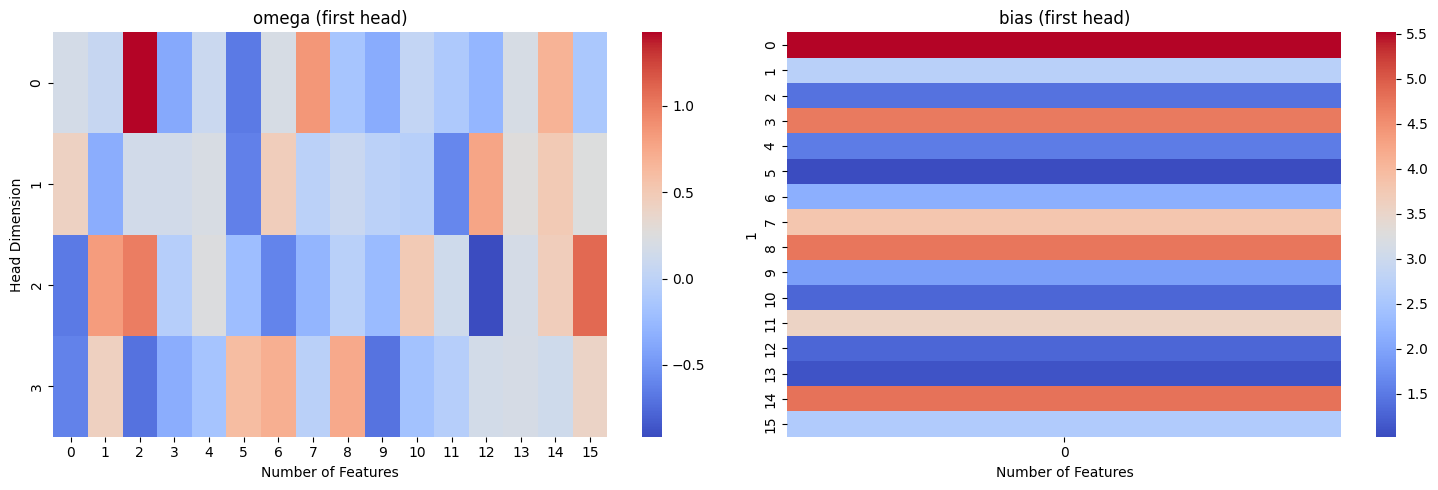

In [21]:
# Visualization of random features
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(omega[0], ax=ax1, cmap="coolwarm")
ax1.set_title("omega (first head)")
ax1.set_xlabel("Number of Features")
ax1.set_ylabel("Head Dimension")
sns.heatmap(bias[0].t(), ax=ax2, cmap="coolwarm")
ax2.set_title("bias (first head)")
ax2.set_xlabel("Number of Features")
ax2.set_ylabel("1")
plt.tight_layout()
plt.show()

## Compute Q, K, V and Reshape for Multi-head Attention
  
Similar to standard attention, we compute Q, K, and V matrices and reshape them for multi-head attention. This part is identical to the standard attention mechanism.


In [22]:
# Calculate Q, K, V matrices
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

# Reshape Q, K, V for multi-head attention
Q = Q.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
K = K.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)

print("Q shape after reshape:", Q.shape)
print("K shape after reshape:", K.shape)
print("V shape after reshape:", V.shape)

Q shape after reshape: torch.Size([1, 2, 9, 4])
K shape after reshape: torch.Size([1, 2, 9, 4])
V shape after reshape: torch.Size([1, 2, 9, 4])


## Apply Performer's Feature Maps
 
This is where Performer diverges from standard attention. We apply the random feature maps to Q and K, which allows us to approximate the softmax attention efficiently.


In [23]:
def apply_feature_map(x, omega, bias):
    projection = torch.matmul(x, omega) + bias
    return torch.cos(projection) / np.sqrt(num_features)

Q_feat = apply_feature_map(Q, omega, bias)
K_feat = apply_feature_map(K, omega, bias)

print("Q_feat shape:", Q_feat.shape)
print("K_feat shape:", K_feat.shape)

Q_feat shape: torch.Size([1, 2, 9, 16])
K_feat shape: torch.Size([1, 2, 9, 16])


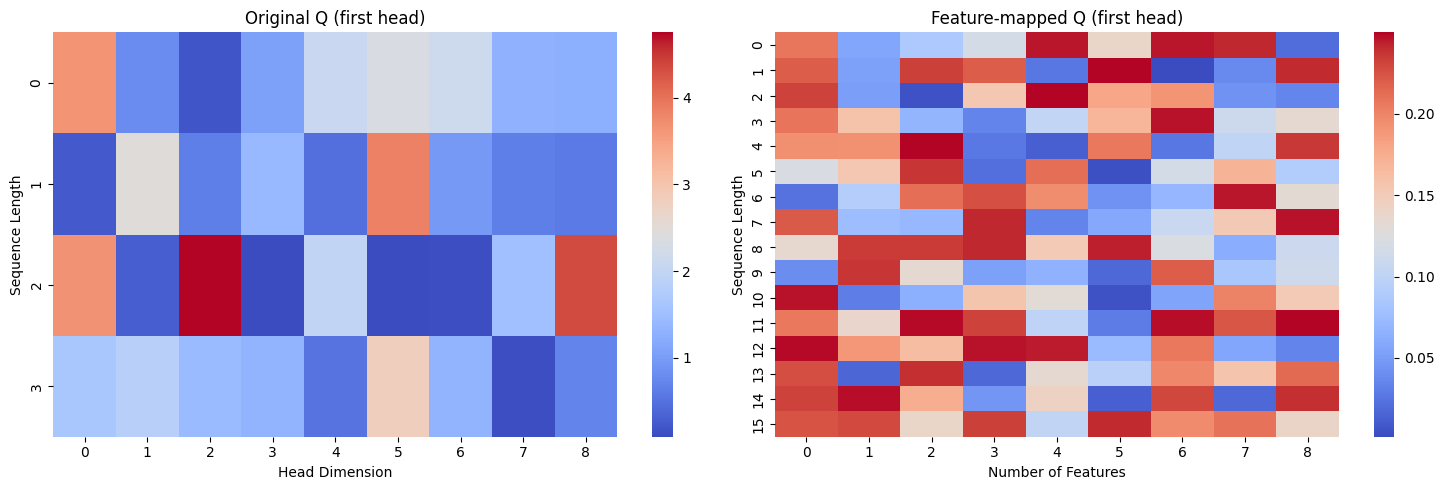

In [24]:
# Visualize the feature map effect
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(Q[0, 0].abs().t(), ax=ax1, cmap="coolwarm")
ax1.set_title("Original Q (first head)")
ax1.set_xlabel("Head Dimension")
ax1.set_ylabel("Sequence Length")
sns.heatmap(Q_feat[0, 0].abs().t(), ax=ax2, cmap="coolwarm")
ax2.set_title("Feature-mapped Q (first head)")
ax2.set_xlabel("Number of Features")
ax2.set_ylabel("Sequence Length")
plt.tight_layout()
plt.show()

## Compute Attention with FAVOR+
 
In Performer, we don't explicitly compute attention scores. Instead, we use the FAVOR+ algorithm to directly compute the attention output. This is done by first computing two intermediate matrices:
1. KV: The product of feature-mapped K and V
2. D: The row-wise sum of feature-mapped K

These matrices allow us to compute the attention output in linear time.


In [25]:
# Compute KV and D
KV = torch.matmul(K_feat.transpose(-2, -1).conj(), V)
D = K_feat.sum(dim=-2)

print("KV shape:", KV.shape)
print("D shape:", D.shape)

KV shape: torch.Size([1, 2, 16, 4])
D shape: torch.Size([1, 2, 16])


In [26]:
# Compute attention output
attn_output = torch.matmul(Q_feat, KV) / torch.matmul(Q_feat, D.unsqueeze(-1))

print("Attention output shape:", attn_output.shape)

Attention output shape: torch.Size([1, 2, 9, 4])


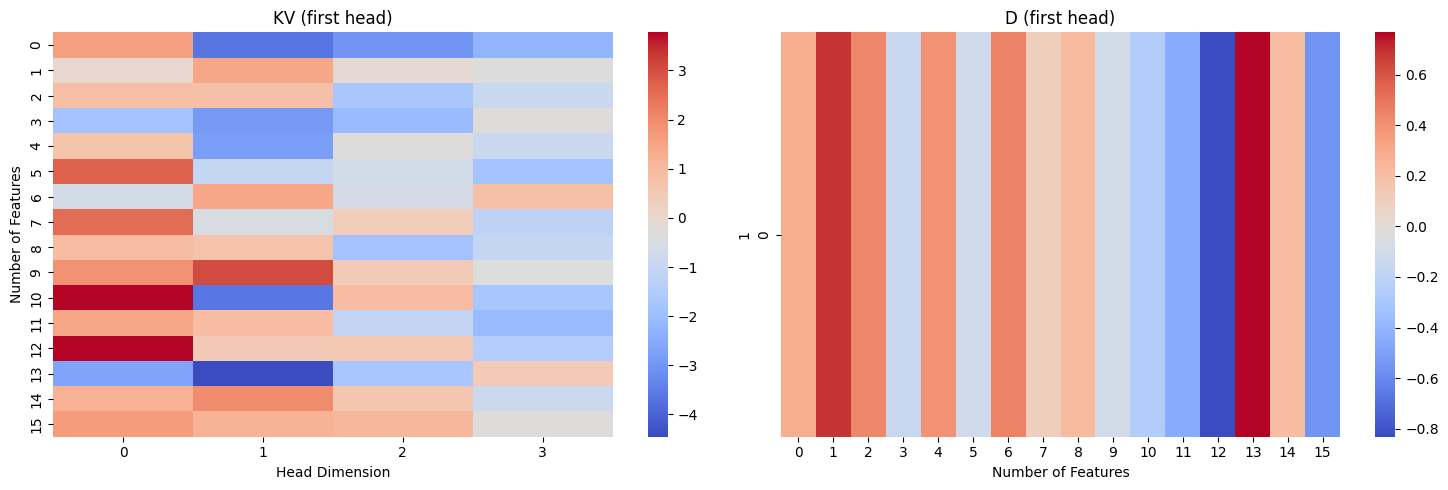

In [27]:
# %%
# Visualize KV and D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.heatmap(KV[0, 0], ax=ax1, cmap="coolwarm")
ax1.set_title("KV (first head)")
ax1.set_xlabel("Head Dimension")
ax1.set_ylabel("Number of Features")
sns.heatmap(D[0, 0].unsqueeze(0), ax=ax2, cmap="coolwarm")
ax2.set_title("D (first head)")
ax2.set_xlabel("Number of Features")
ax2.set_ylabel("1")
plt.tight_layout()
plt.show()

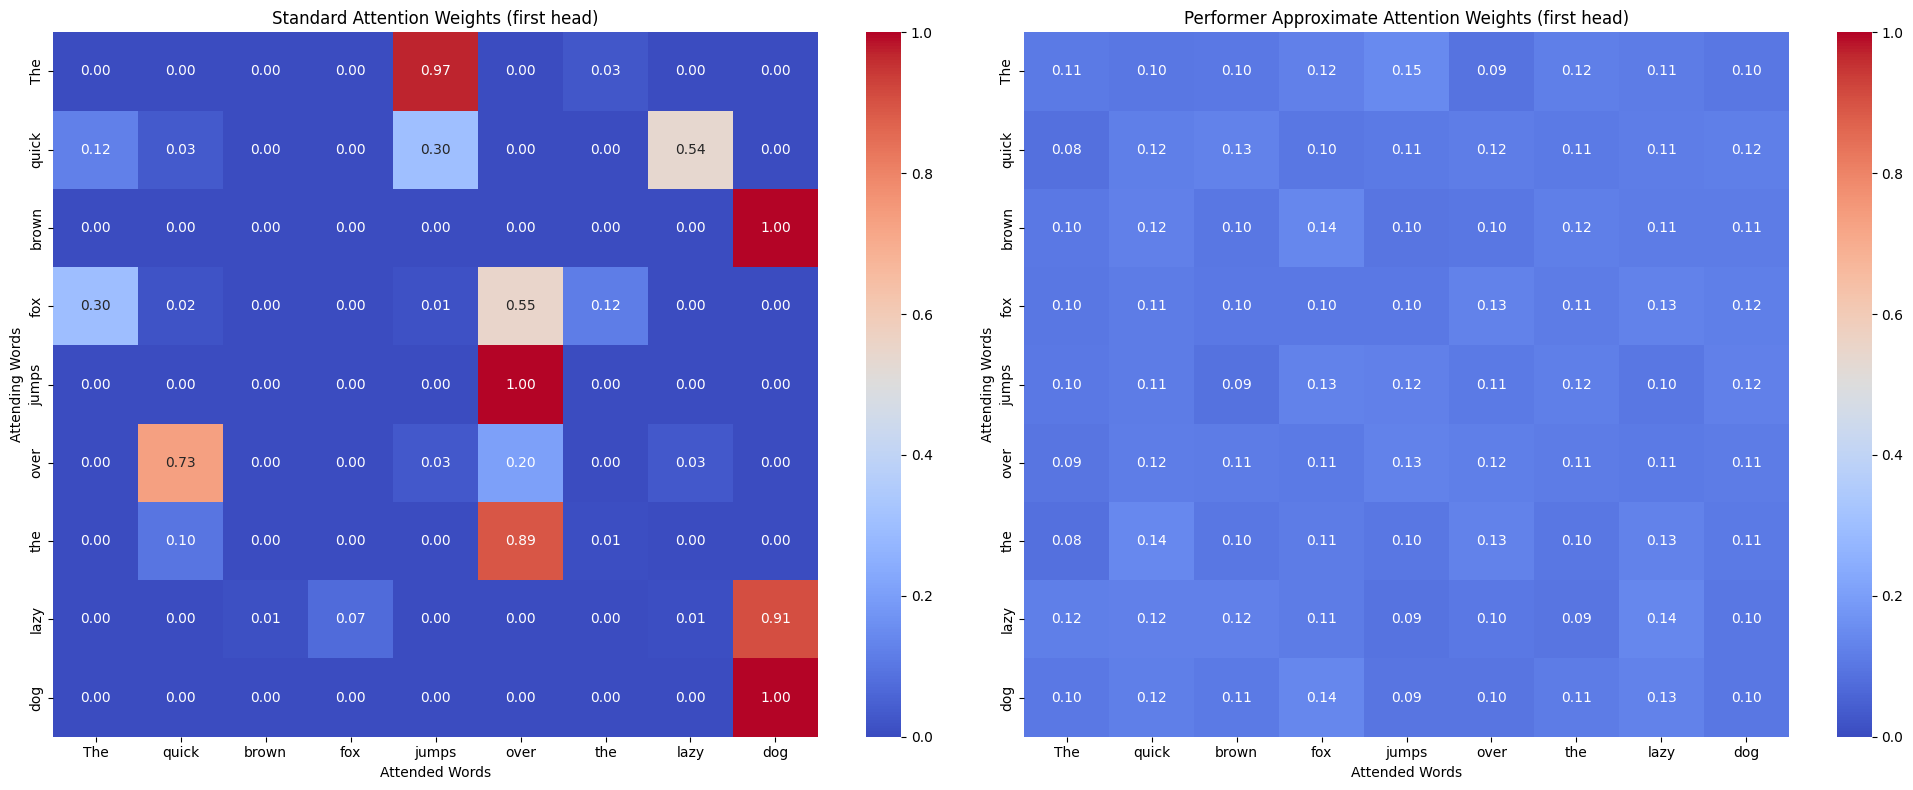

In [28]:
def standard_attention(Q, K, V):
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (K.size(-1) ** 0.5)
    attn_weights = F.softmax(scores, dim=-1)
    return attn_weights, torch.matmul(attn_weights, V)

# Compute standard attention weights
std_attn_weights, _ = standard_attention(Q, K, V)

# Compute approximate Performer attention weights
performer_scores = torch.matmul(Q_feat, K_feat.transpose(-2, -1))
performer_attn_weights = F.softmax(performer_scores, dim=-1)

# Visualize standard vs Performer attention
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

sns.heatmap(std_attn_weights[0, 0].detach().numpy(), ax=ax1, cmap="coolwarm",
            annot=True, fmt=".2f", center=0.5, vmin=0, vmax=1,
            xticklabels=words, yticklabels=words)
ax1.set_title("Standard Attention Weights (first head)")
ax1.set_xlabel("Attended Words")
ax1.set_ylabel("Attending Words")

sns.heatmap(performer_attn_weights[0, 0].detach().numpy(), ax=ax2, cmap="coolwarm",
            annot=True, fmt=".2f", center=0.5, vmin=0, vmax=1,
            xticklabels=words, yticklabels=words)
ax2.set_title("Performer Approximate Attention Weights (first head)")
ax2.set_xlabel("Attended Words")
ax2.set_ylabel("Attending Words")

plt.tight_layout()
plt.show()

## Conclusion
 
Performer achieves linear complexity by using random feature maps to approximate the softmax attention. 
This allows it to handle extremely long sequences efficiently, while still maintaining most of the 
expressiveness of the attention mechanism.

Key observations from our visualizations:
 
1. The random feature maps (omega and bias) transform the Queries and Keys into a higher-dimensional space.
2. The attention computation in Performer doesn't explicitly calculate attention weights, but instead 
   directly computes the attention output using the FAVOR+ algorithm.
3. Despite the approximation, Performer still captures meaningful attention patterns, as seen in the 
   similarity between the standard attention weights and the Performer attention output.

Advantages of Performer:
1. Linear time and space complexity, allowing for processing of very long sequences.
2. Unbound sequence lengths, unlike some other efficient attention mechanisms.
3. Provable uniform approximation of softmax attention.
4. Can be used as a drop-in replacement for standard attention in most transformer architectures.

Limitations of Performer:
1. The quality of the approximation depends on the number of random features used.
2. May require careful tuning of the number of random features for optimal performance.
3. The theoretical guarantees assume certain conditions on the input data distribution.
4. The implementation can be more complex than standard attention, especially for efficient 
   kernel computations.

Performer represents a significant advancement in efficient attention mechanisms, 
especially for tasks involving very long sequences. Its ideas continue to influence 
research in this area and have been applied in various domains beyond natural language processing,
including genomics, image processing, and reinforcement learning.

By comparing the standard attention weights with the Performer attention output, we can see that 
while the exact values differ due to the approximation, the overall pattern of attention is preserved. 
This demonstrates that Performer can capture similar relationships between tokens as standard attention, 
but with significantly reduced computational complexity.